In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import ElasticNetCV
from sklearn import cross_validation
import numpy as np
from sklearn import metrics
from FeatureWeights import FeatureWeights
from sklearn.pipeline import Pipeline
import os
import cvxpy as cvx
import warnings
warnings.filterwarnings('ignore')

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 29 days


## Data loading

We use genus relative abundances from American Gut dataset. This data was downloaded August 6, 2016.

In [2]:
df = pd.read_table("../data/AG/notrim/ag-cleaned_L6.txt")
print df.shape

(9792, 2381)


It appears this data set has 9792 rows and 2381 columns. Taking a look at the first few rows from column 466 and onwrds:

In [3]:
df.iloc[:,466:].head()

,HMP_SITE,k__Archaea;p__Crenarchaeota,k__Archaea;p__Euryarchaeota,k__Archaea;p__[Parvarchaeota],k__Bacteria;p__,k__Bacteria;p__AD3,k__Bacteria;p__Acidobacteria,k__Bacteria;p__Actinobacteria,k__Bacteria;p__AncK6,k__Bacteria;p__Aquificae,...,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__,k__Bacteria;p__WS4;c__;o__;f__;g__,k__Bacteria;p__ZB3;c__;o__;f__;g__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__CM44,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__B-42,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__Truepera,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus
0,FECAL,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001755,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FECAL,0.0,0.000000,0.0,0.0,0.0,0.000000,0.001911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FECAL,0.0,0.000000,0.0,0.0,0.0,0.000000,0.218124,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SKIN,0.0,0.000000,0.0,0.0,0.0,0.000781,0.642207,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FECAL,0.0,0.000066,0.0,0.0,0.0,0.000000,0.051438,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Get only subset of samples that are fecal and save this subset to a new Data Frame df_rel.

In [4]:
df_rel = df[df["HMP_SITE"] == "FECAL"]
print df_rel.shape

(8724, 2381)


After removing non fecal samples, we are left with 8724 rows. 

In [5]:
df_rel.iloc[:,466:].head()

,HMP_SITE,k__Archaea;p__Crenarchaeota,k__Archaea;p__Euryarchaeota,k__Archaea;p__[Parvarchaeota],k__Bacteria;p__,k__Bacteria;p__AD3,k__Bacteria;p__Acidobacteria,k__Bacteria;p__Actinobacteria,k__Bacteria;p__AncK6,k__Bacteria;p__Aquificae,...,k__Bacteria;p__WS3;c__PRR-12;o__Sediment-1;f__PRR-10;g__,k__Bacteria;p__WS4;c__;o__;f__;g__,k__Bacteria;p__ZB3;c__;o__;f__;g__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__CM44,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Deinococcaceae;g__Deinococcus,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__B-42,k__Bacteria;p__[Thermi];c__Deinococci;o__Deinococcales;f__Trueperaceae;g__Truepera,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Meiothermus,k__Bacteria;p__[Thermi];c__Deinococci;o__Thermales;f__Thermaceae;g__Thermus
0,FECAL,0.0,0.000000,0.0,0.0,0.0,0.0,0.001755,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FECAL,0.0,0.000000,0.0,0.0,0.0,0.0,0.001911,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FECAL,0.0,0.000000,0.0,0.0,0.0,0.0,0.218124,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FECAL,0.0,0.000066,0.0,0.0,0.0,0.0,0.051438,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,FECAL,0.0,0.000000,0.0,0.0,0.0,0.0,0.021382,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# BMI data setup

Convert the BMI_CORRECTED column to numeric variables:

In [6]:
df_rel[["BMI_CORRECTED"]] = df_rel[["BMI_CORRECTED"]].apply(lambda x: pd.to_numeric(x, errors = "coerce"))

Remove any rows that did not have BMI_CORRECTED values (probably got coerced to NA when we converted BMI from string to numeric above): 

In [7]:
df_clean = df_rel.dropna()
print df_clean.shape

(1772, 2381)


After removing the the missing BMI_CORRECTED rows, we are left with 1772 samples. Lets take a look at the summary statistics of the BMI_CORRECTED values to see if we have sensible BMI's:

In [8]:
df_clean["BMI_CORRECTED"].describe()

count    1772.000000
mean       23.284814
std         5.347557
min         9.630000
25%        20.180000
50%        22.820000
75%        25.830000
max        59.880000
Name: BMI_CORRECTED, dtype: float64

It seems we have a reasonable distributions of BMIs, although the min and max BMI's that we have might be considered outliers. It may be sensible to remove BMI's above and below the 95 and 5 percentiles respectively. Lets explore the relationship between age and BMI_corrected to see if anything pops out:

shape of data: (1606, 2381)


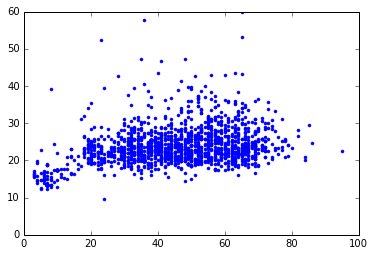

In [9]:
import matplotlib.pyplot as plt

%matplotlib inline
df_rel[["AGE_CORRECTED"]] = df_rel[["AGE_CORRECTED"]].apply(lambda x: pd.to_numeric(x, errors = "coerce"))
df_clean = df_rel.dropna()
print "shape of data:", df_clean.shape
plt.plot(df_clean.AGE_CORRECTED, df_clean.BMI_CORRECTED, '.')

It appears that there are two distinc distribution of BMIs before and after age 20. It also looks like there are about a dozen or so very large BMIs but we will keep them in the data and remove samples from individuals 20 years or younger:

In [10]:
df_age_20 = df_clean[df_clean.AGE_CORRECTED>20]

Create a numpy 2D array X for features and the numpy array 1D array y. We use this for training the models using the Scikit-learn framework: 

In [11]:
y = np.array(df_age_20["BMI_CORRECTED"])
X = np.array(df_age_20.iloc[:,467:])
print "y shape", y.shape
print "X shape", X.shape

y shape (1436,)
X shape (1436, 1914)


We use 90% of the data to train and validate models and report results using 10-fold cross validation. The remaining 10% is a "hold-out, use only once" data snippet. 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print X_train.shape
print y_train.shape

(1292, 1914)
(1292,)


## Regression Benchmarks on AG data

We use 10-fold cross validation to evaluate a number of different regression algorithms. As many regression models require parameters that must be selected through gridsearch, for each fold we perform additional cross validation (using 3 folds) to determine hyperparameters via gridsearch.  The "pipeline" class in Scikit-learn gives us an easy interface to perform such nested cross validation and preventing leakage. 

We measure error using "mean absolute error".

We start with the elastic net linear regression algorithm where we have two hyperparemters to search through (l1 and l2 penatlies). 

In [35]:
ENet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=10, normalize=False, 
                            max_iter=3000, tol=0.0001, cv=3, copy_X=True, n_jobs=-1)

ENET_scores =-1*cross_validation.cross_val_score(ENet, X_train, y_train, cv=10, scoring = 'mean_absolute_error')
print np.mean(ENET_scores), np.std(ENET_scores)

3.41460732621 0.22166670894


Next we test the mean absolute accuracy of Random Forests. For Random Forests we do not perform nested cross validation over the hyperparameters and just use the default parameters with a very large number of trees. 

In [14]:
RF = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RF_scores = -1*cross_validation.cross_val_score(RF, X_train, y_train, cv=10, scoring = 'mean_absolute_error')
print np.mean(RF_scores), np.std(RF_scores)

3.34753226029 0.261042531623


Next we use the K-nearest neighbor (KNN) algorithm. We gridsearch over the number of neighbors ranging from 1 to 10.

In [15]:
KNN = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=dict(n_neighbors=range(1,11)), n_jobs = -1, scoring = 'mean_absolute_error')
KNN_scores = -1*cross_validation.cross_val_score(KNN, X_train, y_train, cv=10, scoring = 'mean_absolute_error')
print np.mean(KNN_scores), np.std(KNN_scores)

3.56851981614 0.246206957151


Next we use KNN but with the feature weight learning as a preprocessing step. We only gridsearch over KNN paramters: the number of neighbors (1-10) and the metric (p = 1 and p = 2). Since feature weight learning is computationally expensive, we use a bagging ensemble approach that performs the pipeline with 100 samples at a time and the number of ensembles is 50 (no bootstrapping is used):

In [16]:
FW = FeatureWeights(upper_bound=False, cvx_solver=cvx.SCS, obj_norm=2, bagged_estimate=False)

KNN = GridSearchCV(estimator=KNeighborsRegressor(), 
                   param_grid=dict(n_neighbors=range(1,11), p=[1,2]), 
                   n_jobs = 1, scoring = 'mean_absolute_error')        

metric_KNN = Pipeline([('metric', FW), ('knn', KNN)])

metric_KNN_scores =-1*cross_validation.cross_val_score(BaggingRegressor(metric_KNN,max_samples=100, bootstrap = False, 
                                                                     n_estimators=50, n_jobs = -1), 
                                                     X_train, y_train, cv=10, scoring = 'mean_absolute_error', )
print np.mean(metric_KNN_scores), np.std(metric_KNN_scores)

3.30488440762 0.231256472536


To make a more fair comparison with KNN, we also perform KNN with bagging but without feature weight learning as a preprocessing step:

In [17]:
KNN = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=dict(n_neighbors=range(1,11)), n_jobs = 1, scoring = 'mean_absolute_error')
bagged_KNN_scores = -1*cross_validation.cross_val_score(BaggingRegressor(KNN,max_samples=100, bootstrap = True, 
                                                                     n_estimators=50, n_jobs = -1), X_train, y_train, cv=10, scoring = 'mean_absolute_error')
print np.mean(bagged_KNN_scores), np.std(bagged_KNN_scores)

3.43032466181 0.222186577607


We also see if using feature weight learning as a preprocessing step would affect the elastic net. Again, we use bagging with 100 samples and 50 draws to allow feature weight learning to be more scalable (and perhaps more robust? TBD). ENET parameters are again found using gridsearch over the same params as initial modeling: 

In [18]:
FW = FeatureWeights(upper_bound=False, cvx_solver=cvx.SCS, obj_norm=2)


ENet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=10, normalize=False, 
                            max_iter=3000, tol=0.0001, cv=3, copy_X=True, n_jobs=1)

metric_ENET = Pipeline([('metric', FW), ('enet', ENet)])

metric_ENET_scores =-1*cross_validation.cross_val_score(BaggingRegressor(metric_ENET,max_samples=100, bootstrap = False, 
                                                                     n_estimators=50, n_jobs = -1), 
                                                     X_train, y_train, cv=10, scoring = 'mean_absolute_error')

print np.mean(metric_ENET_scores), np.std(metric_ENET_scores)

3.43762430569 0.243418786689


Again, to make a more fair comparison with vanilla ENET, we also perform ENET with bagging but without feature weight learning as a preprocessing step:

In [19]:
ENet = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=0.001, n_alphas=10, normalize=True, 
                            max_iter=1000, tol=0.0001, cv=3, copy_X=True, n_jobs=-1)

bagged_ENET_scores =-1*cross_validation.cross_val_score(BaggingRegressor(ENet,max_samples=50, bootstrap = False, 
                                                                     n_estimators=10), 
                                                     X_train, y_train, cv=10, scoring = 'mean_absolute_error', )

print np.mean(bagged_ENET_scores), np.std(bagged_ENET_scores)

3.44282188322 0.209521362455


##Test on LS

We now test the models that we have investigated on a completely different hold out. Our hold out is the LS dataset prepared by Justine Debelius and the BMI prepared by Larry Smarr. We merge the data with the AG dataset and impute 0 for microbiobes that were not found in the LS stool samples.

In [20]:
LS_AG_df = pd.read_csv("../data/AG-LS-BMI.csv")
LS_AG_df.head()

,BMI_CORRECTED,k__Archaea.p__Crenarchaeota,k__Archaea.p__Euryarchaeota,k__Archaea.p__.Parvarchaeota.,k__Bacteria.p__,k__Bacteria.p__AD3,k__Bacteria.p__Acidobacteria,k__Bacteria.p__Actinobacteria,k__Bacteria.p__AncK6,k__Bacteria.p__Aquificae,...,k__Bacteria.p__WS4.c__.o__.f__.g__,k__Bacteria.p__ZB3.c__.o__.f__.g__,k__Bacteria.p__.Thermi..c__Deinococci.o__Deinococcales.f__Deinococcaceae.g__CM44,k__Bacteria.p__.Thermi..c__Deinococci.o__Deinococcales.f__Deinococcaceae.g__Deinococcus,k__Bacteria.p__.Thermi..c__Deinococci.o__Deinococcales.f__Trueperaceae.g__,k__Bacteria.p__.Thermi..c__Deinococci.o__Deinococcales.f__Trueperaceae.g__B.42,k__Bacteria.p__.Thermi..c__Deinococci.o__Deinococcales.f__Trueperaceae.g__Truepera,k__Bacteria.p__.Thermi..c__Deinococci.o__Thermales.f__Thermaceae.g__Meiothermus,k__Bacteria.p__.Thermi..c__Deinococci.o__Thermales.f__Thermaceae.g__Thermus,data.source
0,24.07,0.0,0.0,0,0.0,0,0.0,0.041194,0,0,...,0,0,0,0.0,0,0,0.0,0,0.0,AG
1,21.93,0.0,0.0,0,0.0,0,0.0,0.001482,0,0,...,0,0,0,0.0,0,0,0.0,0,0.0,AG
2,22.22,0.0,0.0,0,0.0,0,0.0,0.000000,0,0,...,0,0,0,0.0,0,0,0.0,0,0.0,AG
3,14.96,0.0,0.0,0,0.0,0,0.0,0.146594,0,0,...,0,0,0,0.0,0,0,0.0,0,0.0,AG
4,24.96,0.0,0.0,0,0.0,0,0.0,0.003996,0,0,...,0,0,0,0.0,0,0,0.0,0,0.0,AG


Sanity check that we indeed have 81 LS samples after the merge with the AG dataset and put LS data in its own data frame:

In [21]:
LS_df = LS_AG_df[LS_AG_df["data.source"] != "AG"]
print LS_df.shape

(81, 1916)


Place the genus relative abundaces as features in X_LS numpy 2D array and the BMI values as a numpy 1D array y_LS:

In [22]:
X_LS = np.array(LS_df.iloc[:,1:-1])
y_LS = np.array(LS_df.BMI_CORRECTED)

Train Random Forest model on AG data set:

In [23]:
RF = RandomForestRegressor(n_estimators=1000, n_jobs=-1)
RF.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=-1, oob_score=False,
           random_state=None, verbose=0, warm_start=False)

Evaluate trained Random Forest model on the LS data and compute the mean absolute error:

In [24]:
np.mean(abs(RF.predict(X_LS)-y_LS))

3.256793952527957

Also evalute trained Random Forest model on the hold out of the AG data that we prepared above:

In [25]:
np.mean(abs(RF.predict(X_test)-y_test))

4.0843226369897501

Now "train" KNN model by gridsearching over the different number of neighbors (ranging from 1 to 10) using 3-fold cross validation (same parameter selection method as before) on the AG data set:

In [26]:
KNN = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=dict(n_neighbors=range(1,11)), n_jobs = -1, 
                   scoring = 'mean_absolute_error')
KNN.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0)

Evaluate the trained KNN model on the LS data and compute the mean absolute error:

In [27]:
np.mean(abs(KNN.predict(X_LS) - y_LS))

2.176037037037037

Also evalute trained KNN model on the hold out of the AG data that we prepared above:

In [28]:
np.mean(abs(KNN.predict(X_test) - y_test))

4.1722430555555565

Train another KNN but with feature weight learning as a preprocessing step. Again we perform girdsearch over the number of neighbors (and this type also the metric of 1 or 2 norm) using 3-fold CV. As before, because of the computational complexity of feature weight learning, we perform a bagged estimate.

In [29]:
FW = FeatureWeights(upper_bound=False, cvx_solver=cvx.SCS, obj_norm=2, bagged_estimate=False)

KNN = GridSearchCV(estimator=KNeighborsRegressor(), 
                   param_grid=dict(n_neighbors=range(1,11), p=[1,2]), 
                   n_jobs = 1, scoring = 'mean_absolute_error')        

metric_KNN = Pipeline([('metric', FW), ('knn', KNN)])

Bagged_metric = BaggingRegressor(metric_KNN,max_samples=200, bootstrap = False, n_estimators=100, n_jobs= -1)
Bagged_metric.fit(X_train, y_train)

BaggingRegressor(base_estimator=Pipeline(steps=[('metric', FeatureWeights(bagged_estimate=False, cvx_solver='SCS', niter=10,
        normalize_condition_number=True, num_samples=100, obj_norm=2,
        round_weights=True, sparsify_weights=True, upper_bound=False)), ('knn', GridSearchCV(cv=None, error_score='raise',
       estimator=KNeigh...10]},
       pre_dispatch='2*n_jobs', refit=True, scoring='mean_absolute_error',
       verbose=0))]),
         bootstrap=False, bootstrap_features=False, max_features=1.0,
         max_samples=200, n_estimators=100, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

Evaluate the trained KNN with feature weight learning as preprocessing step on the LS data and compute the mean absolute error:

In [30]:
np.mean(abs(y_LS-Bagged_metric.predict(X_LS)))

0.80411952576915513

Also evalute trained KNN model with feature weight learning as preprocessing step on the hold out of the AG data that we prepared above:

In [31]:
np.mean(abs(y_test-Bagged_metric.predict(X_test)))

3.9768692300485009

Save LS results to CSV:

In [32]:
df_LS_res = pd.DataFrame({"LS_RF_pred": RF.predict(X_LS), "LS_Metric_KNN_pred": Bagged_metric.predict(X_LS), 
                        "LS_BMI": y_LS, "sample_id": LS_df["data.source"]})
df_LS_res.to_csv("LS_res.csv", index = False)

## Iterative weight learning (experimental!)

In [35]:
from FeatureWeightsRegressor import FeatureWeightsRegressor
FWR = FeatureWeightsRegressor(num_sample_neighbors=10, n_iter = 50)
FWR.fit(X_train, y_train)

FeatureWeightsRegressor(n_iter=50, num_sample_neighbors=10)

In [36]:
FWR.predict_tester(X_LS[:5,:], y_LS[:5])

****************************************
iter 0
unique rows for X_nearest (50, 1914)
optimal_inaccurate 0.7244
****************************************
iter 1
unique rows for X_nearest (50, 1914)
optimal_inaccurate 1.0942
****************************************
iter 2
unique rows for X_nearest (50, 1914)
optimal_inaccurate 2.2014
****************************************
iter 3
unique rows for X_nearest (50, 1914)
optimal_inaccurate 1.444
****************************************
iter 4
unique rows for X_nearest (50, 1914)
optimal_inaccurate 1.0738
****************************************
iter 5
unique rows for X_nearest (50, 1914)
optimal_inaccurate 2.3248
****************************************
iter 6
unique rows for X_nearest (50, 1914)
optimal_inaccurate 1.9068
****************************************
iter 7
unique rows for X_nearest (50, 1914)
optimal_inaccurate 0.6476
****************************************
iter 8
unique rows for X_nearest (39, 1914)
optimal_inaccurate 1.646
***

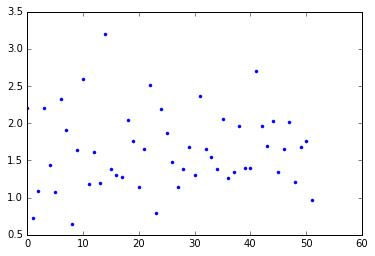

In [37]:
plt.plot(FWR.errs, ".")

In [43]:
np.mean(abs(np.median(np.array(FWR.iter_preds[-10:]).squeeze(), axis = 0) - y_LS[:5]))

1.5960666666666661

In [44]:
weights = np.array(FWR.weights).squeeze()
print weights.shape

(50, 1914)


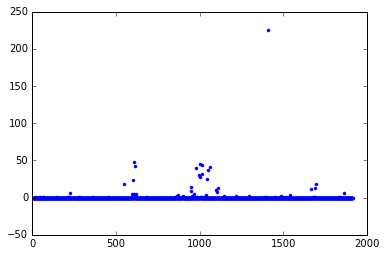

In [47]:
plt.plot(weights[-2,:], ".")

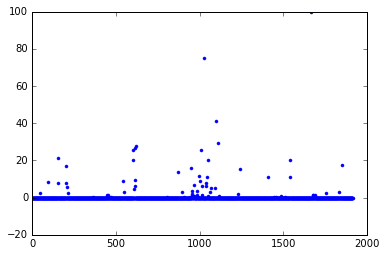

In [48]:
plt.plot(weights[-3,:], ".")

In [51]:
found_weights = weights[-2,:]

non_zero_weights = found_weights[found_weights> 0]

len(non_zero_weights)

289

In [53]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(n_components=3)
weights_pc = pca.fit_transform(weights)    
print weights_pc.shape

(50, 3)


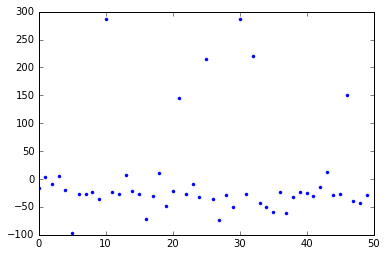

In [58]:
plt.plot(weights_pc[0:,2], ".")